# Business Context

** Desafio **
Criar um modelo de alta performance na identificação de clientes em churn.

Sobre a Empresa:
A TopBottonBank é um novo banco com atuação na europa.
 
**Entregável:**
Ao final da sua consultoria, você precisa entregar ao CEO da TopBottomBank um modelo em produção, que receberá uma base de clientes via API e desenvolverá essa base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Perguntas a serem respondidas no report final:
1-Qual a taxa de Churn atual da empresa?
2-Como a taxa de Churn varia por mês?
3-Qual a Performance do modelo em classificar os clientes como churns?
4-Qual o Faturamento da empresa, se ela impedir que os clientes de entrar em Churn através do seu modelo?
5-Qual o valor de um cupom de desconto você daria para o cliente, a fim de evitar churn? E qual o custo total desse incentivo para a empresa?

**Index:**
 - 1.0 Problema de Negócio
 - 1.1 Importações de bibliotecas
 - 2.0 Coleta de Dados
 - 3.0 Descrição dos Dados
 - 4.0 Limpeza de dados
 - 5.0 Feature Engineering
 - 6.0 EDA
 - 7.0 Data Preparation
 - 8.0 Feature Selection
 - 9.0 Model Selection
 - 10.0 Tunning/Treinamento do modelo
 - 11.0 API
 
**Estrátegia:**

3.0 Coleta de Dados:
Coletar os dados utilizando pd.read_csv().

4.0 Descrição dos Dados:
- Descrever as seguintes infos por feature: percentual de missing, valores únicos,     percentual de valores únicos, tipos de dados, skew, kurtosis.
- Descrever Gender vs Exited.
- Descrever Geography vs Exited.
- Descrever HasCrCard vs Exited 
- Descrever IsActiveMember vs Exited
- Descrever a variável 'type' com relação ao target.
- Descrever outras variáveis conforme for pertinente.
- Investigar a presença de Outliers.

5.0 Limpeza de dados:
- Investigar e eliminar os outliers


6.0 Feature Engineering

7.0 EDA

8.0 Teste de Hipoteses

9.0 Split Data

10.0 Data Preparation

11.0 Balanciamento dos Dados

12.0 Feature Selection

13.0 Model Selection

14.0 Tunning/Treinamento do modelo

15.0 API

# Imports

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score, f1_score, recall_score

## Helper Functions

In [2]:
def multi_boxplots(df, variables: list) -> None:

    """
    Function to check for outliers visually through a boxplot

    data: DataFrame

    variable: list of numerical variables
    """

    # set of initial plot posistion
    n = 1

    plt.figure(figsize=(18, 10))
    for column in df[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.boxplot(x=column, data=df)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()
    
def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()

def cramer_v(var_x, var_y):
    """
    Function to calculate the Cramers v correlation.

    """
    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# Data Colection

In [3]:
churn = pd.read_csv('data/churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Description

**Book de Variáveis:**

Age: Idade do cliente.

Balance: Quantidade de dinheiro na

CreditScore: Score de crédito do cliente.

CustomerId: Identificador unico do cliente.

EstimatedSalary: Salário estimado do cliente.

Exited: Variável target se ocorreu ou não churn do cliente.

Gender: Genêro do cliente.

Geography: Localizaçao do cliente.

HasCrCard: Flag se o cliente possui um cartão de crédito ou não

IsActiveMember: Flag se o cliente é ativo ou não.

RowNumber: Número da linha no dataset.

Surname: Sobrenome do cliente.

Ternure: Quantidade em anos que o cliente ainda está no banco ( no-churn ) e ela também diz quanto tempo o cliente ficou no banco até o churn.

In [4]:
# Describe
pd.DataFrame({'missing' :churn.isna().mean(),
              'uniques' :churn.nunique(),
              'dtypes'  :churn.dtypes,
              'min'     :churn.min(),
              'mean'    :churn.mean(),
              'median'  :churn.median(),
              'max'     :churn.max(),
              'skew'    :churn.skew(),
              'kurtosis':churn.kurtosis()})

,missing,uniques,dtypes,min,mean,median,max,skew,kurtosis
Age,0.0,70,int64,18,3.892180e+01,3.700000e+01,92,1.011320,1.395347
Balance,0.0,6382,float64,0,7.648589e+04,9.719854e+04,250898,-0.141109,-1.489412
CreditScore,0.0,460,int64,350,6.505288e+02,6.520000e+02,850,-0.071607,-0.425726
CustomerId,0.0,10000,int64,15565701,1.569094e+07,1.569074e+07,15815690,0.001149,-1.196113
EstimatedSalary,0.0,9999,float64,11.58,1.000902e+05,1.001939e+05,199992,0.002085,-1.181518
Exited,0.0,2,int64,0,2.037000e-01,0.000000e+00,1,1.471611,0.165671
Gender,0.0,2,object,Female,NaN,NaN,Male,NaN,NaN
Geography,0.0,3,object,France,NaN,NaN,Spain,NaN,NaN
HasCrCard,0.0,2,int64,0,7.055000e-01,1.000000e+00,1,-0.901812,-1.186973
IsActiveMember,0.0,2,int64,0,5.151000e-01,1.000000e+00,1,-0.060437,-1.996747


 - Temos dados de diferentes escalas
 - 'Customerid' e 'RowNumber' é um idientificador único podemos eliminar ou utiliza-lo como index do dataframe.
 - As variáveis 'HasCrCard' 'IsActiveMember' são categoricas ordinais iremos alterar o seu tipo para category.

## Target - Exited

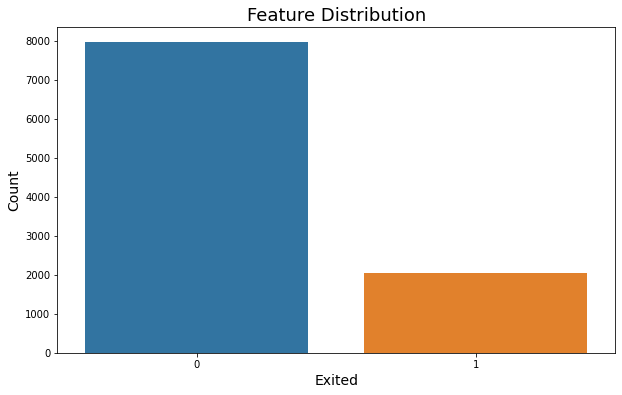

In [5]:
# Checkando o balanciamento da variável Target
ax = sns.countplot(x='Exited', hue=None, data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Exited', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Podemos observar que as classes da variável Target esta desbalanciada.

## Descrever Gender vs Exited

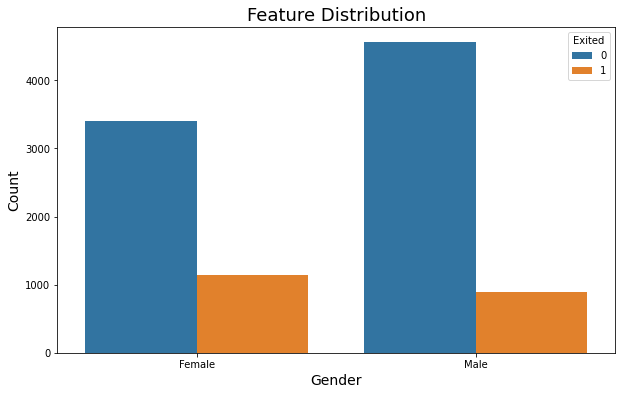

In [6]:
ax = sns.countplot(x='Gender', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

 - Aparentemente não existe uma concentração do evento de 'Churn' conforme o genero.

## Descrever Geography vs Exited

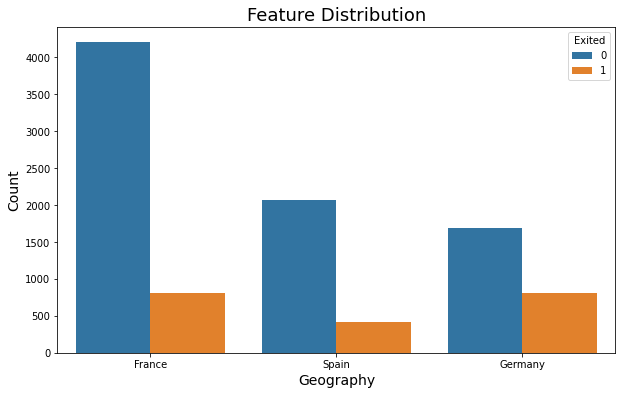

In [7]:
ax = sns.countplot(x='Geography', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Geography', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [8]:
# Percentual de observações por valores Geography
churn.groupby('Geography').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

Geography
France     50.14
Germany    25.09
Spain      24.77
Name: RowNumber, dtype: float64

- Notamos que proporcionalmente parece ocorrer um maior churn de clientes da Alemanha. A mesma possui comente 25% das observações porém possui mais eventos churn que as demais categorias.

## Descrever HasCrCard vs Exited

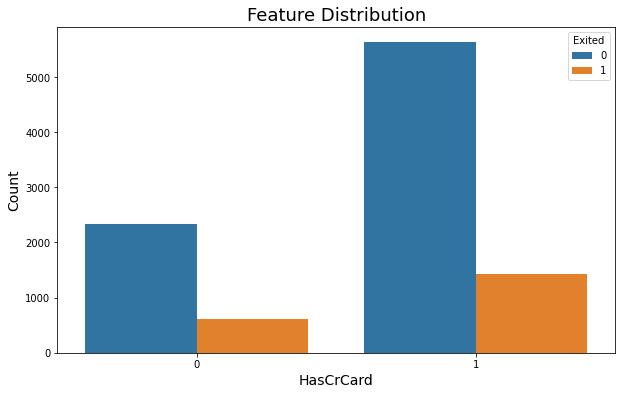

In [9]:
ax = sns.countplot(x='HasCrCard', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('HasCrCard', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [10]:
# Percentual de observações por valores HasCrCard
churn.groupby('HasCrCard').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

HasCrCard
0    29.45
1    70.55
Name: RowNumber, dtype: float64

- Devido a maior concentração de obseravções com cartão de credito temos também maior numero de eventos de churn.

## Descrever IsActiveMember vs Exited

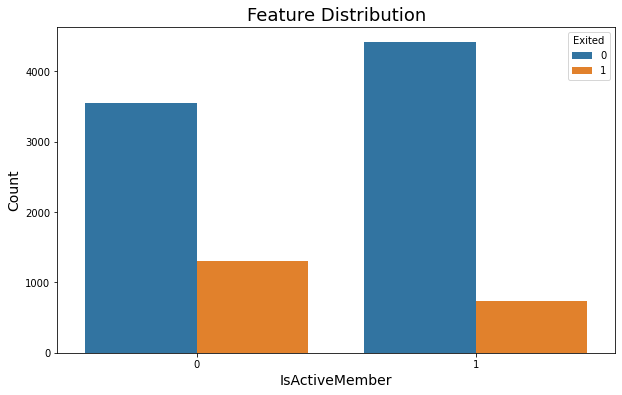

In [11]:
ax = sns.countplot(x='IsActiveMember', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('IsActiveMember', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [12]:
# Percentual de observações por valores HasCrCard
churn.groupby('IsActiveMember').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

IsActiveMember
0    48.49
1    51.51
Name: RowNumber, dtype: float64

 - Em um primeiro momento notamos que a inatividade leva a um maior churn. Os eventos estão distribuídos porém com maior quantidade de eventos de churn na categoria de inatividade.

## Alterando os tipos das variáveis 'HasCrCard', 'IsActiveMember', Exited

In [13]:
# Alterando o tipo de dados para category
colunas = ['HasCrCard','IsActiveMember', 'Exited', 'Surname', 'Geography','Gender']

for col in colunas:
    churn[col] = churn[col].astype('category')

In [14]:
# checkando os tipos
churn.dtypes

RowNumber             int64
CustomerId            int64
Surname            category
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited             category
dtype: object

## Checkando a Presença de Outliers

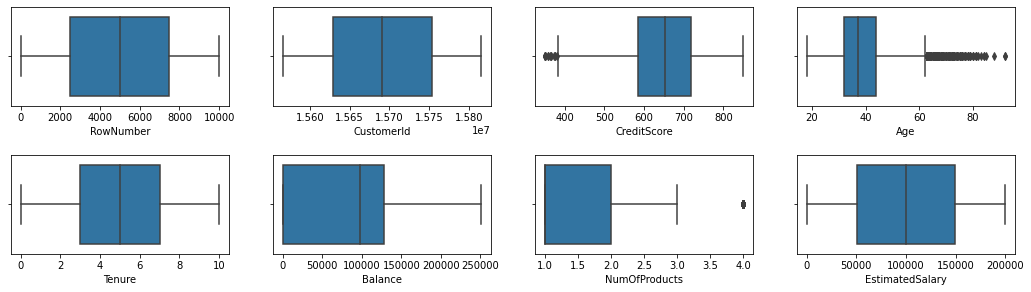

In [15]:
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

 - Observamos Outliers nas variáveis 'CreditScore', 'Age','NumOfProducts'

### CreditScore

In [16]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['CreditScore'], .25)
Q3 = np.quantile(churn['CreditScore'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

O limite inferior é 383.0
O limite superior é 919.0


 - Filtrando somente o limite inferior, pois no boxplot observamos outliers somente no limite inferior.

### Age

In [17]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['Age'], .25)
Q3 = np.quantile(churn['Age'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

O limite inferior é 14.0
O limite superior é 62.0


 - Filtrando somente o limite superior, pois no boxplot observamos outliers somente no limite superior.

### NumOfProducts

Iremos filtrar todas as observações com 4 produtos, pois conforme o boxplot os outliers estão nesse patamar.

# Limpeza de Dados

 ## Cleaning Outliers.

In [18]:
# Filtrando 'CreditScore' somente o limite inferior.
churn = churn.loc[churn['CreditScore']>400, ]

# Filtrando 'Age' somente o limite inferior
churn = churn.loc[churn['Age']<59, ]

# Filtrando 'NumOfProducts'
churn = churn.loc[churn['NumOfProducts']<4, ]

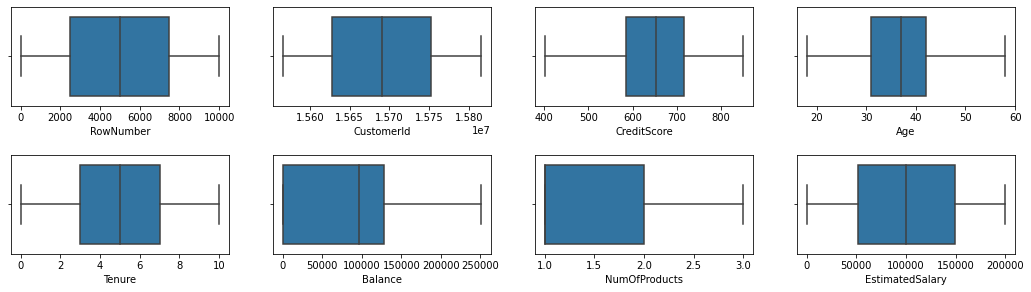

In [19]:
# checking the outliers again.
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

# Feature Engineering

- Eliminar as variáveis RowNumber, CustomersId, Surname(granularidade alta) por apresentarem pouco ganho de informação para a modelagem do nosso problema.
- Criar variável com Kmeans usando k=2. O valor de k é devido a estarmos trabalhando com um problema binário.
- Criar variável EstimatedSalary por location. Distribuição da renda podem nos ajudar na modelagem do problema.
- Binning as variáveis CreditScore, Age, Tenure, Balance, EstimatedSalary. Realizando o Binning dessas variáveis diminuimos a granularidade das mesmas o que irá facilitar a modelagem do problema futuramente.

In [20]:
# Copia do dataset original
dataset = churn.copy()

In [21]:
# Eliminando RowNumber, CustomersId, Surname(granularidade alta)
dataset.drop(['RowNumber','CustomerId','Surname'], inplace=True, axis=1)

In [22]:
# Variável kmeans distancia eucliadiana
# Criando copia
churn_temp = dataset.copy()

# Encoder
enc = OrdinalEncoder()
churn_temp['Gender'] = churn_temp['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
churn_temp['Geography'] = enc.fit_transform(np.array(churn_temp['Geography']).reshape(-1,1))

# kmeans model
model = KMeans(n_clusters=2,init='k-means++')
model.fit(churn_temp)
dataset['kmeans_group'] = model.labels_
dataset['kmeans_group'] = dataset['kmeans_group'].astype('category')

In [23]:
# Criar variável Balance por location
group_balance = dataset.groupby('Geography').agg({'Balance': ['mean']}).reset_index()
group = pd.concat([group_balance['Geography'],group_balance['Balance']['mean']], axis=1)
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [24]:
# Criar variável EstimatedSalary por location
group_balance = dataset.groupby('Geography').agg({'EstimatedSalary': ['mean']}).reset_index()
group = pd.concat([group_balance['Geography'],  group_balance['EstimatedSalary']['mean']], axis=1)
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [25]:
# Binning
# CreditScore
dataset['CreditScore_new'] = pd.qcut(dataset['CreditScore'],q=10)

# Age
dataset['Age_new'] = pd.qcut(dataset['Age'],q=10)

# Tenure
dataset['Tenure_new'] = pd.qcut(dataset['Tenure'],q=10)

# Balance
dataset['Balance_new'] = pd.qcut(dataset['Balance'],q=[.35, .70, 1])

# EstimatedSalary
dataset['EstimatedSalary_new'] = pd.qcut(dataset['EstimatedSalary'],q=10)

In [26]:
# LTV
balance = dataset['Balance'].astype('int64')
dataset['LTV'] = balance / (dataset['Tenure'] + 0.1)

In [27]:
# Dando uma olhada como ficou o dataset
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,kmeans_group,mean_x,mean_y,CreditScore_new,Age_new,Tenure_new,Balance_new,EstimatedSalary_new,LTV
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,62155.348676,100060.32564,"(599.0, 627.0]","(41.0, 44.0]","(1.0, 2.0]","(-0.001, 121942.818]","(100236.02, 119889.26]",0.000000
1,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,62155.348676,100060.32564,"(400.999, 523.0]","(41.0, 44.0]","(7.0, 8.0]","(121942.818, 250898.09]","(100236.02, 119889.26]",19711.111111
2,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,62155.348676,100060.32564,"(678.0, 704.0]","(37.0, 39.0]","(-0.001, 1.0]","(-0.001, 121942.818]","(80486.35, 100236.02]",0.000000
3,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,62155.348676,100060.32564,"(777.0, 850.0]","(48.0, 58.0]","(6.0, 7.0]","(-0.001, 121942.818]","(11.579, 20158.39]",0.000000
4,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,1,62155.348676,100060.32564,"(400.999, 523.0]","(41.0, 44.0]","(3.0, 4.0]","(121942.818, 250898.09]","(60892.784, 80486.35]",34646.585366


# EDA

## Análise Univariada

### Category variables

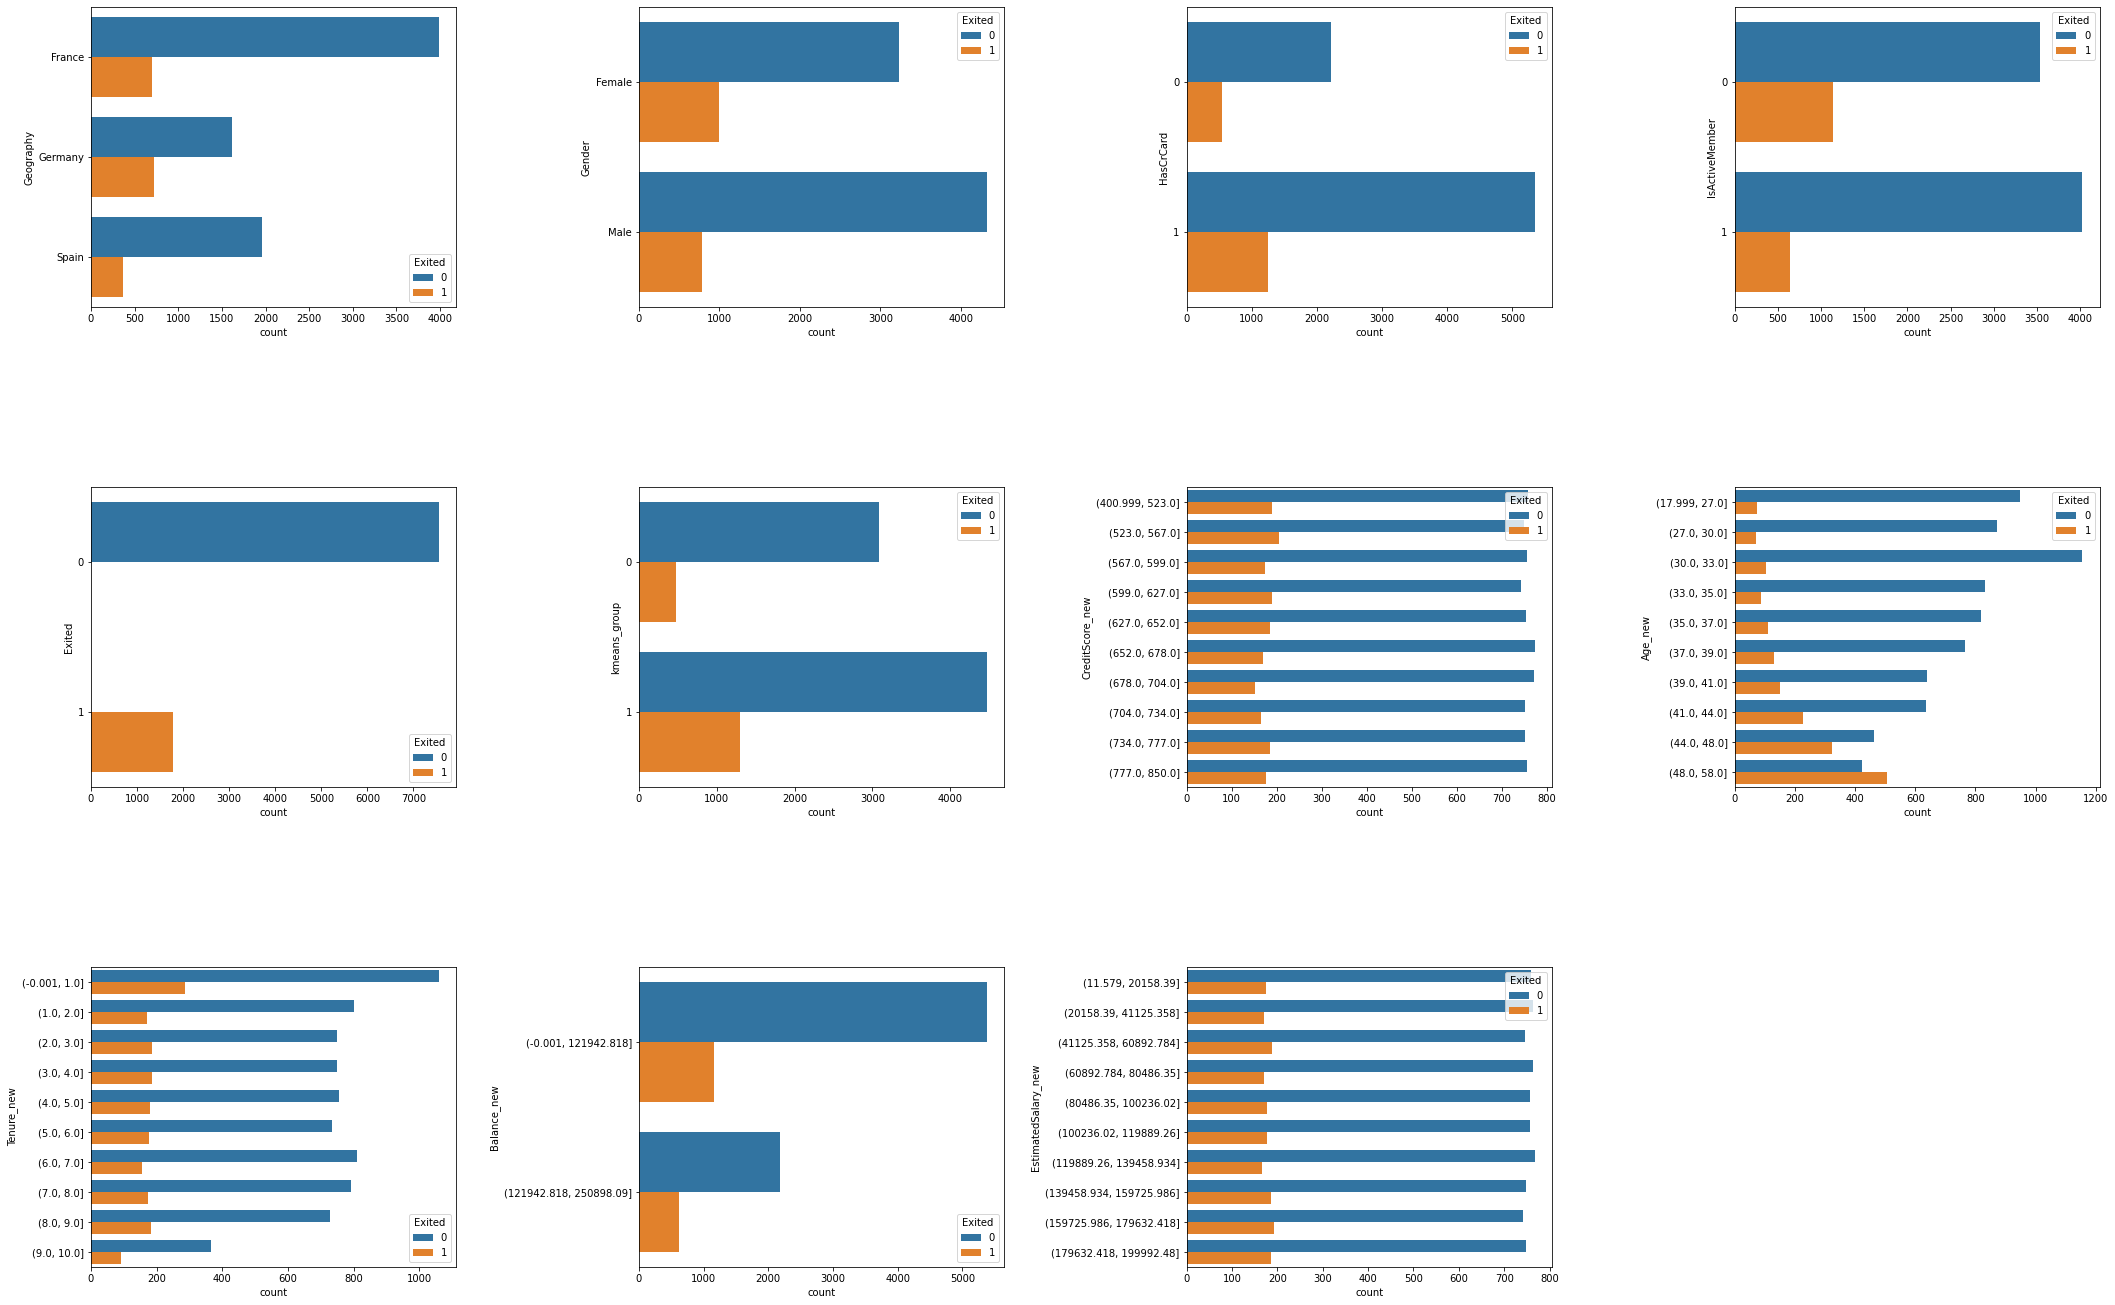

In [28]:
# checking the outliers again.
# Variáveis
variables = dataset.select_dtypes(['category']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=column,hue='Exited', data=dataset)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Os casos de churn paracem diminuir a medida que aumenta a variável 'Ternure'
- Os casos de churn parecem aumentar a medida que a idade dos clientes também aumenta.
- Outro ponto parece haver um maior concetração de churn entre os clientes que não estão ativos.

### Numerical variables

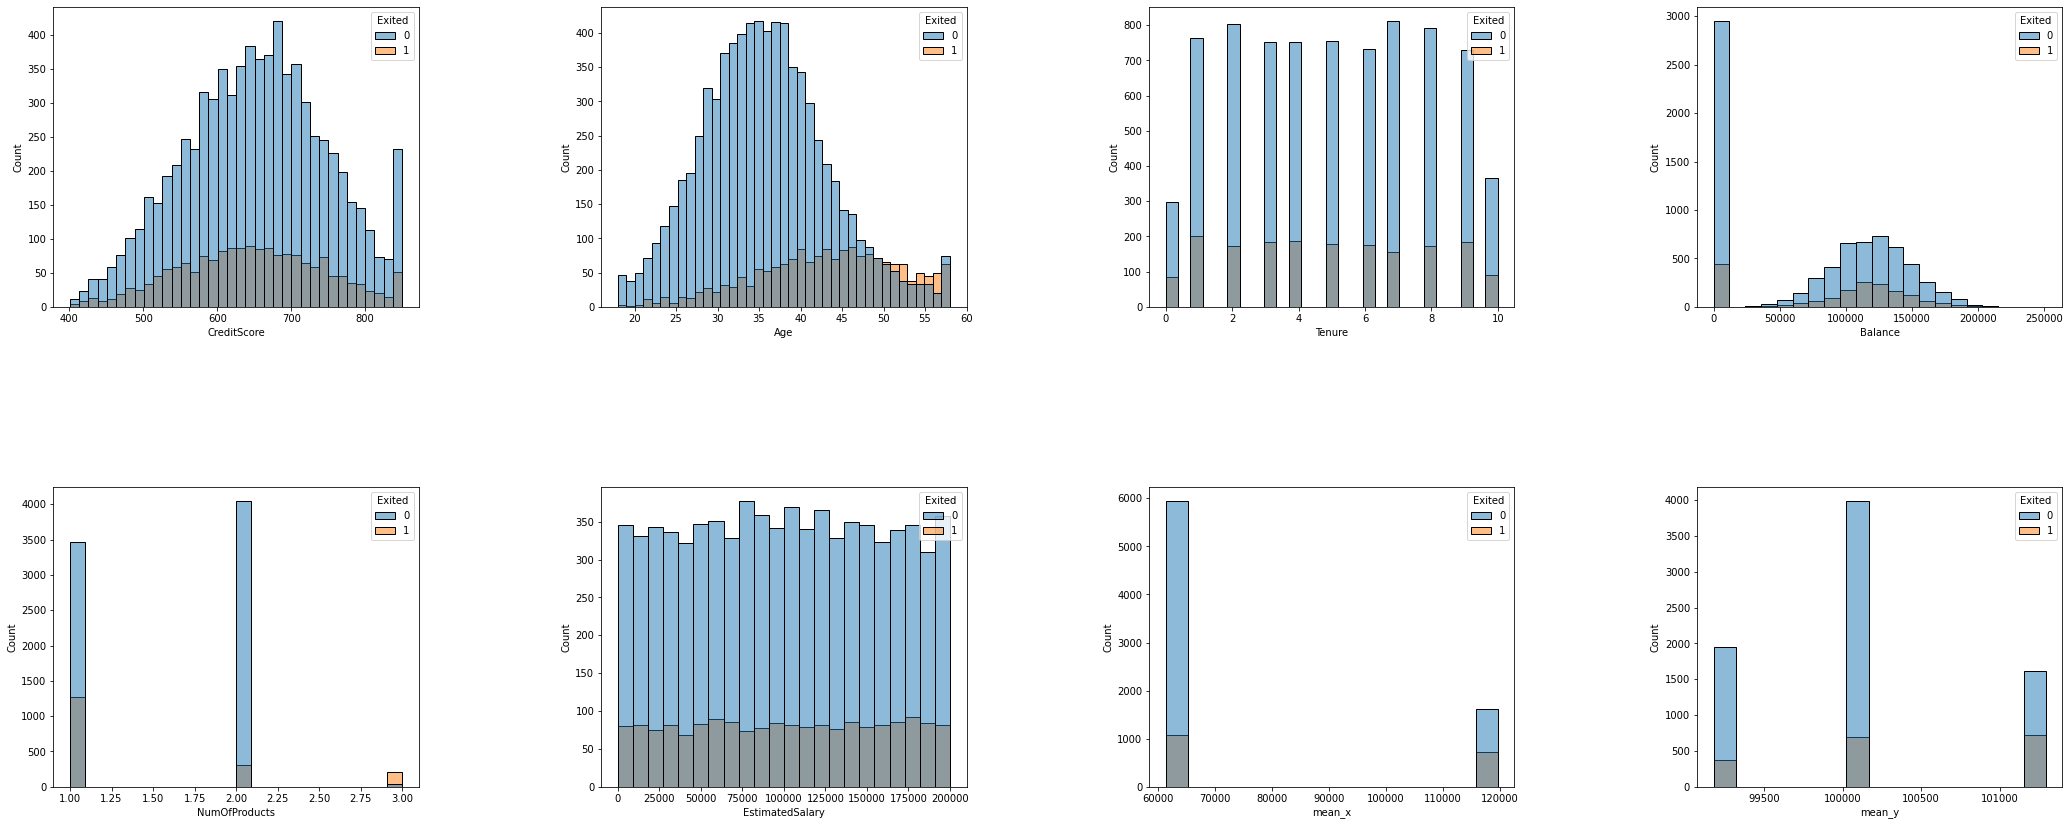

In [29]:
# Antes do feature eng
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
#variables.remove('RowNumber'), variables.remove('CustomerId')

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns[:len(variables)-1]:
    plt.subplot(4, 4, n)
    _ = sns.histplot(data = dataset, x=column, hue='Exited')
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Confirmamos a tendência de maior churn entre clientes com maior idade.
- Observamos também muitos clientes com 'balance' igual a zero, porém seme uma concetração atipica de casos de churn
- Distribuições proximas da normal com um skew fraco.

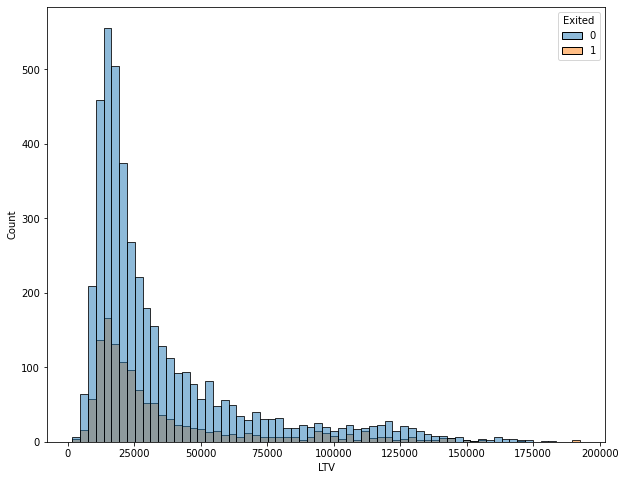

In [30]:
# LTV
LTV = dataset.loc[(dataset['LTV'] != 0) & (dataset['LTV'] < (0.3*1000000)),]

plt.figure(figsize=(10, 8))
sns.histplot(data = LTV, x='LTV', hue='Exited')
plt.show()

- Distribuição com forte skew. Iremos proceder com normalização dos dados na etapa de Feature Eng.

## Análise Multivariada

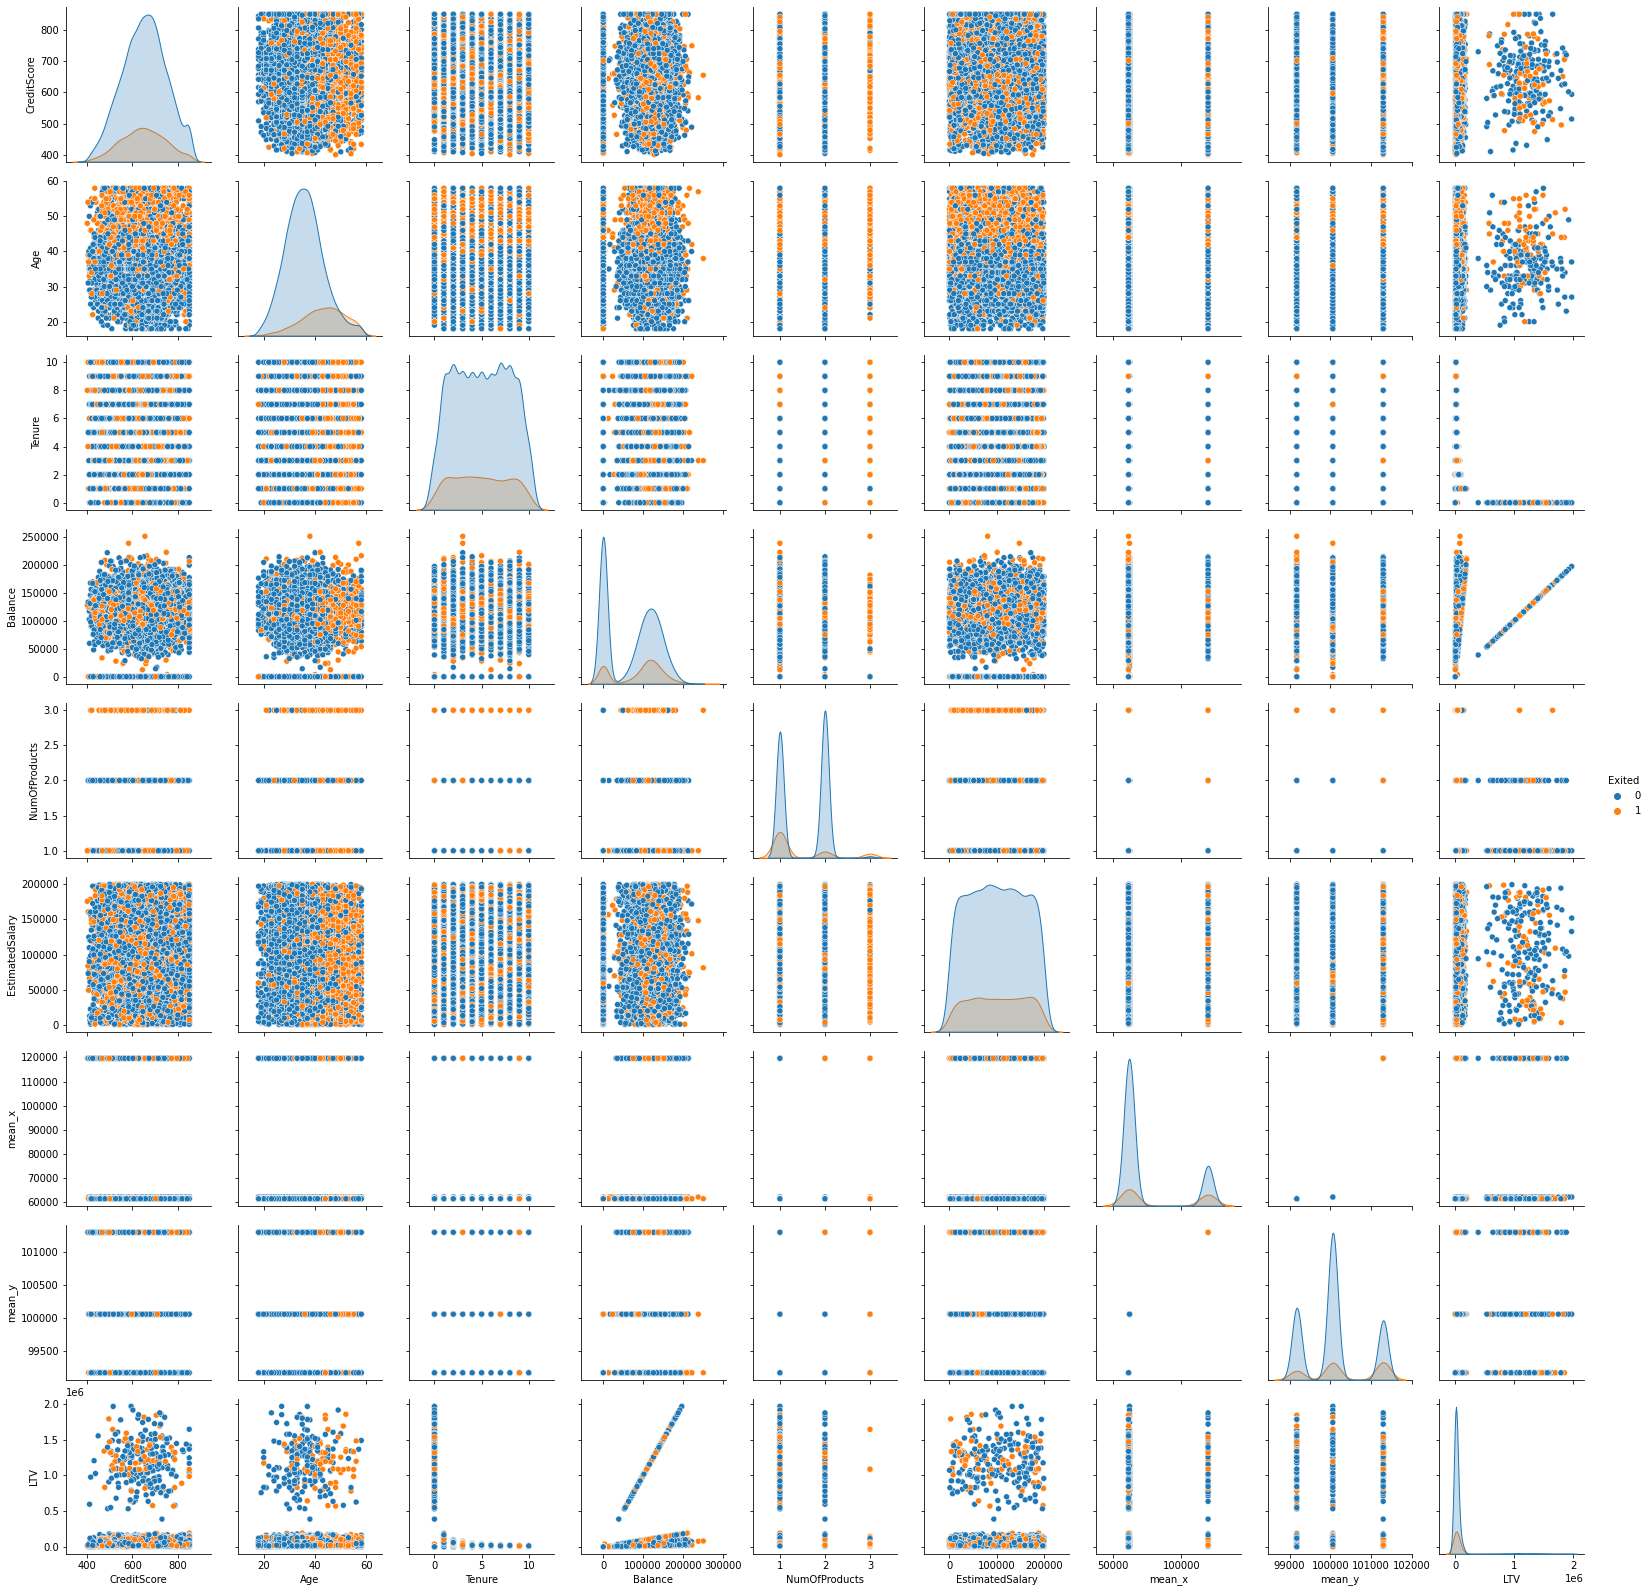

In [32]:
# Variáveis
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
variables.append('Exited')

sns.pairplot(dataset[variables], hue='Exited')

- Não é possível observar nenhuma relação linear entre as variáveis.
- É possivel também notar uma concentração de casos de churn no NumOfProducts igual a 3. 

### Correlations

##### Variáveis Numericas

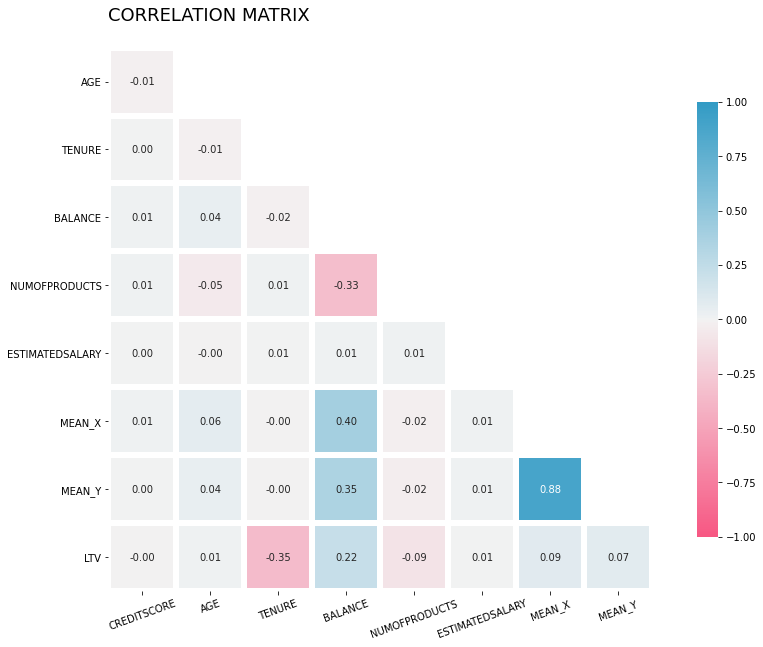

In [37]:
# Pearson correlation Matrix
Myheat_map(dataset =dataset, variaveis=variables)

- Observamos uma grande correlação entre a variavel mean_Y e mean_X iremos excluir uma delas

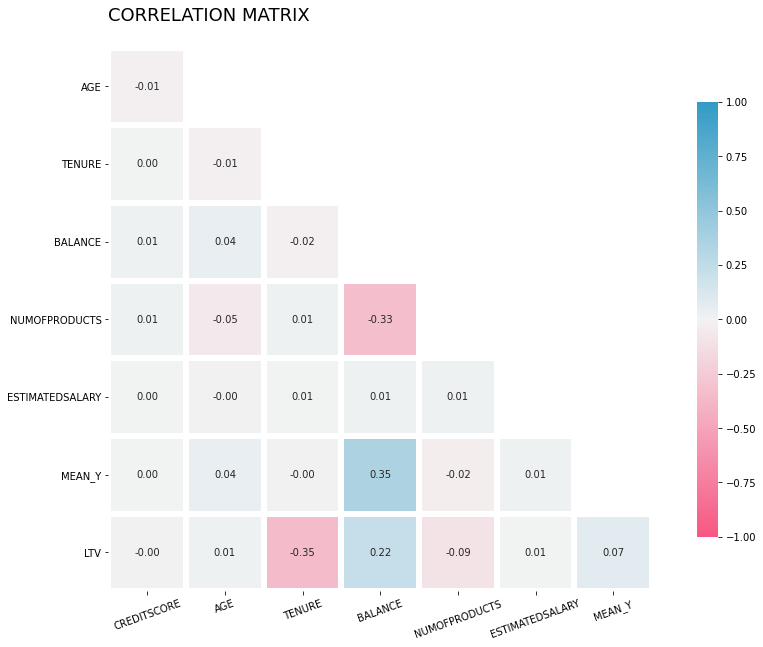

In [38]:
# Removendo a variável mean_x
variables.remove('mean_x')
Myheat_map(dataset =dataset, variaveis=variables)

Text(0.5, 1.0, 'Pointbiserialr')

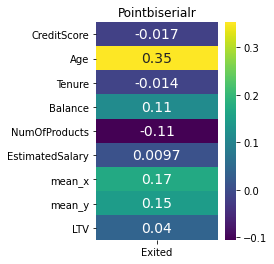

In [39]:
# Numericas com relação a target
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()

# Correlações
corrs = [pointbiserialr(dataset['Exited'], dataset[var])[0] for var in variables]
df_corr = pd.DataFrame({'Exited': corrs}, index=variables)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

- Nenhuma variável com a correlação significante  com relação a variávl Target.

### Variáveis categoricas - cramers v

In [45]:
cols

['Geography',
 'Gender',
 'HasCrCard',
 'IsActiveMember',
 'kmeans_group',
 'CreditScore_new',
 'Age_new',
 'Tenure_new',
 'Balance_new',
 'EstimatedSalary_new',
 'Exited']

Text(0.5, 1.0, 'Cramér V')

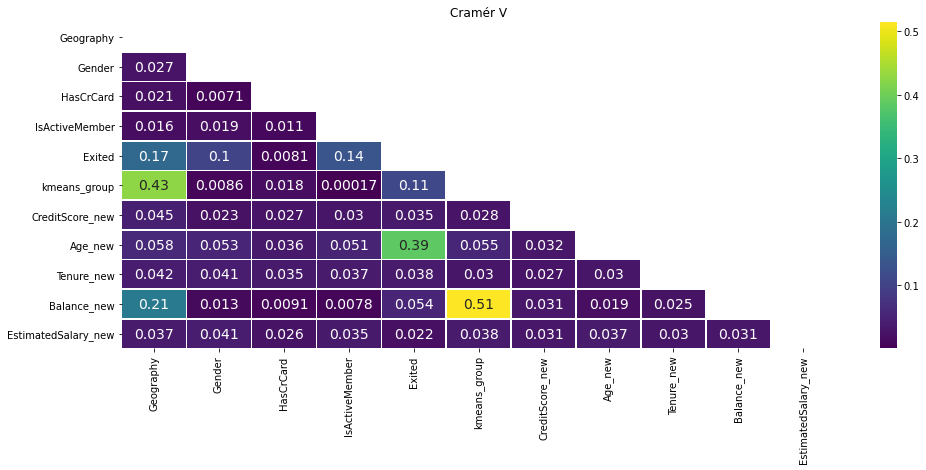

In [46]:
# colunas
cols = dataset.select_dtypes(['category']).columns.to_list()

# Dicionário para registro das correlações
dictt = {
        'Geography': [],
        'Gender': [],
        'HasCrCard': [],
        'IsActiveMember': [],
        'Exited': [],
        'kmeans_group': [],
        'CreditScore_new': [],
        'Age_new': [],
        'Tenure_new': [],
        'Balance_new': [],
        'EstimatedSalary_new': [],
        'Exited': []
        }

for col in cols:
    for col1 in cols:
        corr = cramer_v(dataset[col], dataset[col1])
        dictt[col].append(corr)
        
# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

- Não encontramos nenhuma variável com alta correlação. Estou considerando correlações acima de 0.6 seriam eliminadas.

# Teste de Hipoteses - **Não Feito**

# Split de Dados

In [47]:
# Droping mean_x devido a alta correlação com mean_y
dataset.drop('mean_x', inplace=True, axis=1)

In [48]:
# Selecionando as variáveis que serão utilizadas no treinamento
dataset = dataset[['NumOfProducts', 
                   'HasCrCard',
                   'IsActiveMember',
                   'kmeans_group',
                   'mean_y',
                   'CreditScore_new',
                   'Age_new',
                   'Tenure_new',
                   'Balance_new',
                   'LTV',
                   'Exited']]

dataset.head()

,NumOfProducts,HasCrCard,IsActiveMember,kmeans_group,mean_y,CreditScore_new,Age_new,Tenure_new,Balance_new,LTV,Exited
0,1,1,1,0,100060.32564,"(599.0, 627.0]","(41.0, 44.0]","(1.0, 2.0]","(-0.001, 121942.818]",0.000000,1
1,3,1,0,1,100060.32564,"(400.999, 523.0]","(41.0, 44.0]","(7.0, 8.0]","(121942.818, 250898.09]",19711.111111,1
2,2,0,0,0,100060.32564,"(678.0, 704.0]","(37.0, 39.0]","(-0.001, 1.0]","(-0.001, 121942.818]",0.000000,0
3,2,1,1,0,100060.32564,"(777.0, 850.0]","(48.0, 58.0]","(6.0, 7.0]","(-0.001, 121942.818]",0.000000,0
4,2,0,1,1,100060.32564,"(400.999, 523.0]","(41.0, 44.0]","(3.0, 4.0]","(121942.818, 250898.09]",34646.585366,0


In [49]:
X = dataset.drop('Exited', axis=1)
y = dataset['Exited']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

# Data Preparation

In [50]:
# Instanciando ColumnTransformer
ct = ColumnTransformer([("ordinal", OrdinalEncoder(), ['CreditScore_new', 'Age_new', 'Tenure_new', 'Balance_new']),
                        ("", RobustScaler(), ['mean_y', 'LTV'])],remainder='passthrough')

# Transforming
ct.fit_transform(Xtrain)

array([[7., 9., 8., ..., 1., 1., 0.],
       [7., 2., 9., ..., 1., 0., 1.],
       [9., 8., 4., ..., 1., 1., 1.],
       ...,
       [2., 7., 4., ..., 1., 1., 1.],
       [6., 4., 4., ..., 1., 1., 0.],
       [3., 0., 7., ..., 1., 0., 0.]])

# Balanciamento dos dados

In [51]:
# Adicionando balanciamento de dados ao Pipeline

# Instanciando o balanciador
smt = SMOTETomek(sampling_strategy='minority' ,random_state=42)
pipeline = Pipeline([('ct',ct), ('smt', smt)])

# Transformando
target = pd.DataFrame(pipeline.fit_resample(Xtrain, ytrain)[1])

<AxesSubplot:xlabel='Exited', ylabel='count'>

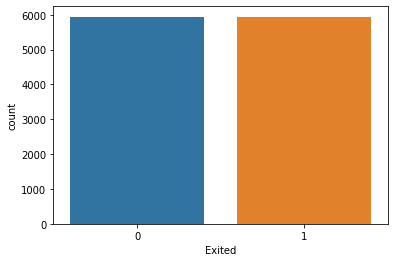

In [52]:
sns.countplot(x='Exited', data=target)

# Feature Selection

In [79]:
#Formando o dataset
X_all = pd.DataFrame(pipeline.fit_resample(Xtrain, ytrain)[0], columns=Xtrain.columns)
target = np.array(target)

# Modelo
model = XGBClassifier()

#Selecionador de Features
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True, )

Feature_Selector.fit(X=X_all,y=target, n_trials=10, random_state=1)

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

8 attributes confirmed important: ['CreditScore_new', 'IsActiveMember', 'NumOfProducts', 'Tenure_new', 'Balance_new', 'Age_new', 'mean_y', 'HasCrCard']
0 attributes confirmed unimportant: []
2 tentative attributes remains: ['kmeans_group', 'LTV']


In [80]:
# Visualizando as variáveis selecioandas
X_subset = Feature_Selector.Subset()
X_subset.head()

,CreditScore_new,IsActiveMember,NumOfProducts,Tenure_new,Balance_new,Age_new,mean_y,HasCrCard
0,-0.488332,8.0,7.0,1.0,1.0,1.0,-0.417282,9.0
1,-0.155540,9.0,7.0,1.0,0.0,2.0,0.582718,2.0
2,0.332441,4.0,9.0,1.0,1.0,1.0,0.582718,8.0
3,1.030375,2.0,3.0,0.0,1.0,2.0,0.582718,8.0
4,-0.488332,1.0,2.0,1.0,1.0,2.0,0.000000,2.0


# Model Selection

Comparando as a performance dos modelos, utilizando todas as variáveis contra utilizando somente as variáveis selecionadas. Podemos observar que somente a Lightgbm obteve uma leve melhora com as variáveis selecionadas quanto os demais tiveram uma leve queda em seus f1 scores.

## Com todas as variáveis

In [81]:
# Modelos
models = [('lr',LogisticRegression()),
          ('knn',KNeighborsClassifier()),
          ('svm',SVC()),
          ('dt',DecisionTreeClassifier()),
          ('rf', RandomForestClassifier()),
          ('lgb',lgb.LGBMClassifier()),
          ('xgboost', XGBClassifier())]

# Resultados
resultados = {'LR': [],
              'KNN': [],
              'SVM': [],
              'DecisionTree': [],
              'RandomForestClassifier': [],
              'LGBM': [],
              'XGBOOST': []}

# Testando algoritmos
for name, model in models:

    # cross-validação
    cv = 10

    # resultado
    resultado = cross_val_score(estimator=model,
                                X=X_all,
                                y=target,
                                scoring='f1',
                                cv=cv,
                                n_jobs=-1)
    
    if name == 'lr':
        resultados['LR'].append(np.mean(resultado))
    elif name == 'knn':
        resultados['KNN'].append(np.mean(resultado)) 
    elif name == 'svm':
        resultados['SVM'].append(np.mean(resultado))
    elif name == 'dt':
        resultados['DecisionTree'].append(np.mean(resultado))
    elif name == 'rf':
        resultados['RandomForestClassifier'].append(np.mean(resultado))
    elif name == 'lgb':
        resultados['LGBM'].append(np.mean(resultado))
    elif name == 'xgboost':
        resultados['XGBOOST'].append(np.mean(resultado))

# Painel
resultados_df = pd.DataFrame(resultados)
resultados_df

,LR,KNN,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.721686,0.863351,0.699966,0.857126,0.901128,0.889717,0.887223


## Com as variáveis selecionadas pelo Boruta.

In [82]:
# Modelos
models = [('lr',LogisticRegression()),
          ('knn',KNeighborsClassifier()),
          ('svm',SVC()),
          ('dt',DecisionTreeClassifier()),
          ('rf', RandomForestClassifier()),
          ('lgb',lgb.LGBMClassifier()),
          ('xgboost', XGBClassifier())]

# Resultados
resultados = {'LR': [],
              'KNN': [],
              'SVM': [],
              'DecisionTree': [],
              'RandomForestClassifier': [],
              'LGBM': [],
              'XGBOOST': []}

# Testando algoritmos
for name, model in models:

    # cross-validação
    cv = 10

    # resultado
    resultado = cross_val_score(estimator=model,
                                X=X_subset,
                                y=target,
                                scoring='f1',
                                cv=cv,
                                n_jobs=-1)
    
    if name == 'lr':
        resultados['LR'].append(np.mean(resultado))
    elif name == 'knn':
        resultados['KNN'].append(np.mean(resultado)) 
    elif name == 'svm':
        resultados['SVM'].append(np.mean(resultado))
    elif name == 'dt':
        resultados['DecisionTree'].append(np.mean(resultado))
    elif name == 'rf':
        resultados['RandomForestClassifier'].append(np.mean(resultado))
    elif name == 'lgb':
        resultados['LGBM'].append(np.mean(resultado))
    elif name == 'xgboost':
        resultados['XGBOOST'].append(np.mean(resultado))

# Painel
resultados_df = pd.DataFrame(resultados)
resultados_df

,LR,KNN,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.717048,0.859591,0.698582,0.853972,0.898727,0.891432,0.885986


# Tunning/Treinamento do modelo